# Import of data and libraries 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import os
import seaborn as sns 

from wordcloud import WordCloud
import re
import nltk 
from nltk.corpus import stopwords
from nltk.stem.porter import *
from tqdm import tqdm
#nltk.download('stopwords')

from IPython.display import display, HTML

In [2]:
os.getcwd()

'/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/Project/bitcoin-prediction-using-twitter/notebooks'

### Manually labelled dataset

Here, we import manually labelled dataset, created by another project group who worked on a similar problem. Given that this dataset was created manually by reliable students, we do believe that this dataset is reliable. However, they only have two labels : positive and negative. We'll need then to find another dataset where we have neutral label.

In [3]:
df = pd.read_csv("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/Project/Social-Media-Posts-On-BTC-main/dataset.csv")

In [4]:
df.label.value_counts()

1    1941
0     959
Name: label, dtype: int64

In [5]:
display(HTML(df.tail().to_html()))

,Post,label
2895,"This piece of NFT Digital art has been sold for 69M, Do you still think 60K Bitcoin is expensive? Bitcoin …",1
2896,📣 's Major Tech Company @meituofficial Puts $40 Million Into 👏 🤩💜 MEITU BUYS CRYPTO💜 Buy Bitcoin…,1
2897,I held out hope for the 40k Bitcoin crash for too long. Regret not longing at 45k when I had the chance. Bought ba…,0
2898,@inmortalcrypto @Cryptodynamix So true. Even better because I bought the shit out of that dip. bitcoin,0
2899,"When Bitcoin reaches its new ATH and some will take its profits, and you start to panic sell, do not sell it…",0


### Kaggle dataset

Here, we import a Kaggle dataset, where we have 3 labels as expected (positive, negative and neutral). However, this dataset might be less reliable, so we need to filter out noisy rows.
(see https://www.kaggle.com/code/sks27199/bit-coin-tweet-sentiment-analysis)

In [6]:
column_name=['created_at','text','screen_name','followers_count','favourite_count','hashtaglist','device_used','feelings']
tweet = pd.read_csv("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/Project/bitcointweets.csv", parse_dates=['created_at'], encoding='utf-8', names=column_name)

In [7]:
tweet.head(7)

,created_at,text,screen_name,followers_count,favourite_count,hashtaglist,device_used,feelings
0,2018-03-23 00:40:32+00:00,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,16522,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral']
1,2018-03-23 00:40:34+00:00,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,1295,0,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral']
2,2018-03-23 00:40:35+00:00,RT @tippereconomy: Another use case for #block...,hojachotopur,6090,0,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
3,2018-03-23 00:40:36+00:00,free coins https://t.co/DiuoePJdap,denies_distro,2626,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
4,2018-03-23 00:40:36+00:00,RT @payvxofficial: WE are happy to announce th...,aditzgraha,184,0,[],"<a href=""http://twitter.com/download/android"" ...",['positive']
5,2018-03-23 00:40:36+00:00,Copy successful traders automatically with Bit...,VictorS61164810,14,0,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive']
6,2018-03-23 00:40:37+00:00,RT @bethereumteam: We're revealing our surpris...,ClarkKalel4,44,0,"[u'surprise', u'presents', u'crypto', u'bitcoin']","<a href=""http://twitter.com/download/android"" ...",['positive']


In [8]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50859 entries, 0 to 50858
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   created_at       50859 non-null  datetime64[ns, UTC]
 1   text             50859 non-null  object             
 2   screen_name      50859 non-null  object             
 3   followers_count  50859 non-null  int64              
 4   favourite_count  50859 non-null  int64              
 5   hashtaglist      50859 non-null  object             
 6   device_used      50859 non-null  object             
 7   feelings         50859 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 3.1+ MB


In [9]:
tweet.describe()

,followers_count,favourite_count
count,5.085900e+04,50859.0
mean,5.200523e+03,0.0
std,6.538524e+04,0.0
min,0.000000e+00,0.0
25%,5.500000e+01,0.0
50%,3.930000e+02,0.0
75%,2.027000e+03,0.0
max,1.019444e+07,0.0


In [10]:
tweet.feelings.value_counts()

['positive']    22937
['neutral']     21939
['negative']     5983
Name: feelings, dtype: int64

## Data Cleaning

First we begin by cleanin this Kaggle Dataset.

In [11]:
tweet = tweet[~tweet['text'].str.contains('RT')] #remove retweets

In [12]:
tweet['hashtaglist']=tweet['hashtaglist'].str.strip('[]') #cleanup square brackets
tweet['feelings']=tweet['feelings'].str.strip('[]')

In [13]:
tweet.head(7)

,created_at,text,screen_name,followers_count,favourite_count,hashtaglist,device_used,feelings
1,2018-03-23 00:40:34+00:00,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,1295,0,u'Bitcoin',"<a href=""http://twitter.com/download/android"" ...",'neutral'
3,2018-03-23 00:40:36+00:00,free coins https://t.co/DiuoePJdap,denies_distro,2626,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'positive'
5,2018-03-23 00:40:36+00:00,Copy successful traders automatically with Bit...,VictorS61164810,14,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'positive'
7,2018-03-23 00:40:37+00:00,One click to start mining cryptocurrencies tog...,cloud_speaker,6560,0,"u'bitcoin', u'PaaS', u'cloudnetwork'","<a href=""http://itunes.apple.com/us/app/twitte...",'neutral'
8,2018-03-23 00:40:38+00:00,"first speaker @digitsu\n\n""how we can get bitc...",MADinMelbourne,2991,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'positive'
9,2018-03-23 00:40:40+00:00,@p0nd3ea Bitcoin wasn't built to live on excha...,APompliano,96897,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'positive'
10,2018-03-23 00:40:40+00:00,@historyinflicks Buddy if I had whatever serie...,martsendo,654,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'positive'


In [14]:
def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'\n', ' ', s)
    s = re.sub(r'\t', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s

tweet['clean_tweet'] = tweet['text'].apply(clean_text)

In [15]:
sample = tweet.head(7)
display(HTML(sample.to_html()))

,created_at,text,screen_name,followers_count,favourite_count,hashtaglist,device_used,feelings,clean_tweet
1,2018-03-23 00:40:34+00:00,@lopp @_Kevin_Pham @psycho_sage @naval But @ProfFaustus (dum b a ss) said you know nothing about #Bitcoin ... 😂😂😂 https://t.co/SBAMFQ2Yiy,BitMocro,1295,0,u'Bitcoin',"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",'neutral',But (dum b a ss) said you know nothing about #Bitcoin ... 😂😂😂
3,2018-03-23 00:40:36+00:00,free coins https://t.co/DiuoePJdap,denies_distro,2626,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",'positive',free coins
5,2018-03-23 00:40:36+00:00,"Copy successful traders automatically with Bitcoin! 💰💰\n\nI copy ""Dividend667"". Do you?\n\n➡️ https://t.co/qb2NXPknVt… https://t.co/Q43fKQRYzx",VictorS61164810,14,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",'positive',"Copy successful traders automatically with Bitcoin! 💰💰 I copy ""Dividend667"". Do you? ➡️"
7,2018-03-23 00:40:37+00:00,One click to start mining cryptocurrencies together with &gt;45K people. #bitcoin https://t.co/rjZC2dia2S #PaaS #cloudnetwork,cloud_speaker,6560,0,"u'bitcoin', u'PaaS', u'cloudnetwork'","<a href=""http://itunes.apple.com/us/app/twitter/id409789998"" rel=""nofollow"">Tweets-for-Mac</a>",'neutral',One click to start mining cryptocurrencies together with &gt;45K people. #bitcoin #PaaS #cloudnetwork
8,2018-03-23 00:40:38+00:00,"first speaker @digitsu\n\n""how we can get bitcoin to be the greatest CASH in the world\nmedium of exchange, not meant… https://t.co/kV3S9kT32A",MADinMelbourne,2991,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",'positive',"first speaker ""how we can get bitcoin to be the greatest CASH in the world medium of exchange, not meant…"
9,2018-03-23 00:40:40+00:00,@p0nd3ea Bitcoin wasn't built to live on exchanges.,APompliano,96897,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",'positive',Bitcoin wasn't built to live on exchanges.
10,2018-03-23 00:40:40+00:00,@historyinflicks Buddy if I had whatever series of 19th diseases Bannon clearly has I'd want to be a bitcoin too.,martsendo,654,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",'positive',Buddy if I had whatever series of 19th diseases Bannon clearly has I'd want to be a bitcoin too.


### Data normalization 

We neeed to have all our tweets in lowercase.

In [16]:
def lower_case(text):
    text = text.lower()
    return text

In [17]:
tweet["clean_tweet"] = tweet["clean_tweet"].apply(lower_case)

### Data Filtering 

We will apply 3 filters to our dataset:
- The first filter on the number of followers. Indeed, we noticed that there are many ads tweets, tweeted by accounts with very few number of followers
- Then, we decided to keep only tweets containing relevant keywords (e.g. "btc", "bitcoin"..)

In [18]:
tweet.describe()

,followers_count,favourite_count
count,2.300700e+04,23007.0
mean,7.123173e+03,0.0
std,8.540312e+04,0.0
min,0.000000e+00,0.0
25%,1.800000e+01,0.0
50%,2.870000e+02,0.0
75%,2.333500e+03,0.0
max,1.019444e+07,0.0


(0.0, 5000.0)

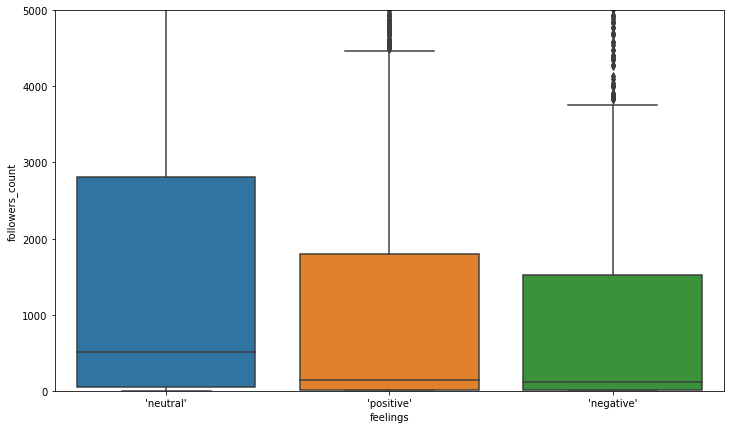

In [19]:
plt.figure(figsize=(12,7))

sns.boxplot(data=tweet, x="feelings" , y="followers_count")

plt.ylim(0, 5e3)

In [20]:
relevant_features = ["text", "screen_name", "clean_tweet", "feelings"]

display(HTML(tweet[tweet.followers_count>1e6][relevant_features].to_html()))

,text,screen_name,clean_tweet,feelings
4189,ICE Agency Charges Payza and Two Canadian Citizens With Bitcoin Money Laundering https://t.co/3DJAeGI81R https://t.co/a83eW5WMej,michael_0000,ice agency charges payza and two canadian citizens with bitcoin money laundering,'neutral'
4558,Social communication is our business https://t.co/aJ9TQygtqv \n#wsj #nytimes #reuters #bloomberg #thestreet… https://t.co/R4PyEjCbMc,socialstartnow,social communication is our business #wsj #nytimes #reuters #bloomberg #thestreet…,'positive'
6154,#Bitcoin spike sparks ‘crypto-jacking’ trend https://t.co/vMz3L3V7RA,RT_com,#bitcoin spike sparks ‘crypto-jacking’ trend,'neutral'
6986,Twitter CEO says Bitcoin will be the world’s primary currency by 2028 https://t.co/QHYtZw5CIn,TheNextWeb,twitter ceo says bitcoin will be the world’s primary currency by 2028,'positive'
8140,Amazing Breakdown Of The 5 Big Cryptos: Uses and Features In The Real World Read More Here: https://t.co/eLX4bWUvJJ… https://t.co/N6zgY6lhaX,nucfootball,amazing breakdown of the 5 big cryptos: uses and features in the real world read more here:,'positive'
8887,"For the first time, NYC buyers pay for condos in bitcoin https://t.co/Zmk7gw2kXc https://t.co/rBUaeUcNCS",nypost,"for the first time, nyc buyers pay for condos in bitcoin",'positive'
14515,Interesting! https://t.co/2xDVAewB5i,icokingmaker,interesting!,'positive'
16816,Bitcoin is bonkers right now. Here's why you shouldn't count it out. https://t.co/UAsojkcRx2 https://t.co/IjdEXecMRf,PopSci,bitcoin is bonkers right now. here's why you shouldn't count it out.,'positive'
18153,Freedom is yours for the taking at The Soba Recovery Center 24 HR Helpline 866 447 5298 https://t.co/dzku4mm40E… https://t.co/4CwNlgfMQM,socialstartnow,freedom is yours for the taking at the soba recovery center 24 hr helpline 866 447 5298,'negative'
25707,Enjoy Family Freedom at The Soba Recovery Center 24 HR Helpline 866 447 5298 https://t.co/dzku4mm40E #sober… https://t.co/ZnLDMP04Qn,socialstartnow,enjoy family freedom at the soba recovery center 24 hr helpline 866 447 5298 #sober…,'positive'


In [21]:
famous_tweets = tweet[tweet.followers_count>=1000]
famous_tweets.feelings.value_counts()

'neutral'     4248
'positive'    2869
'negative'     917
Name: feelings, dtype: int64

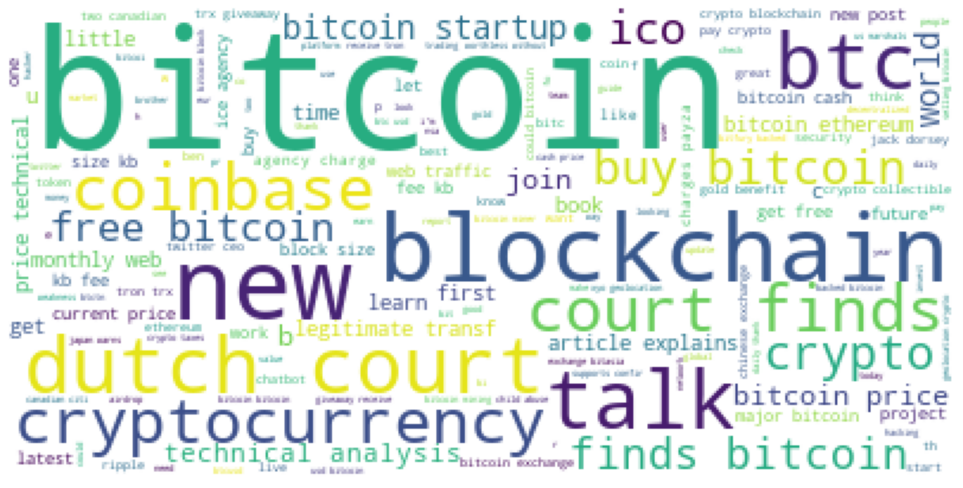

In [22]:
text = famous_tweets["clean_tweet"].to_string()
wordcloud = WordCloud(relative_scaling=0.5 , background_color='white',stopwords=set(stopwords.words('english'))).generate(text)
plt.figure(figsize=(17,17))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [23]:
lexical_dict = ["bitcoin", "bitcoins", "btc", "crypto", "cryptos", "cryptocurrency", "cryptocurrencies", 
                "blockchain", "coin", "coins"]

In [24]:
famous_tweets['keywords'] = famous_tweets["clean_tweet"].apply(lambda sentence: [word for word in sentence.split() if word in set(lexical_dict)] )

famous_tweets["nb_keywords"] = famous_tweets['keywords'].apply(lambda keywords: len(keywords))

/Users/anouaroussalah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/anouaroussalah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
famous_tweets["nb_keywords"].value_counts()

0    4504
1    3007
2     462
3      45
4      16
Name: nb_keywords, dtype: int64

In [26]:
relevant_tweets = famous_tweets[famous_tweets.nb_keywords>0]

In [27]:
relevant_tweets.feelings.value_counts()

'neutral'     2061
'positive'    1017
'negative'     452
Name: feelings, dtype: int64

In [28]:
labels_dict = {"'negative'": 0, "'neutral'" : 1, "'positive'": 2}

In [29]:
relevant_tweets["label"] = relevant_tweets["feelings"].apply(lambda x: labels_dict[str(x)])

/Users/anouaroussalah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
relevant_tweets.head(3)

,created_at,text,screen_name,followers_count,favourite_count,hashtaglist,device_used,feelings,clean_tweet,keywords,nb_keywords,label
3,2018-03-23 00:40:36+00:00,free coins https://t.co/DiuoePJdap,denies_distro,2626,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'positive',free coins,[coins],1,2
7,2018-03-23 00:40:37+00:00,One click to start mining cryptocurrencies tog...,cloud_speaker,6560,0,"u'bitcoin', u'PaaS', u'cloudnetwork'","<a href=""http://itunes.apple.com/us/app/twitte...",'neutral',one click to start mining cryptocurrencies tog...,[cryptocurrencies],1,1
8,2018-03-23 00:40:38+00:00,"first speaker @digitsu\n\n""how we can get bitc...",MADinMelbourne,2991,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'positive',"first speaker ""how we can get bitcoin to be ...",[bitcoin],1,2


In [31]:
final_tweets = relevant_tweets[relevant_tweets['label']!=2]
final_tweets.head(3)

,created_at,text,screen_name,followers_count,favourite_count,hashtaglist,device_used,feelings,clean_tweet,keywords,nb_keywords,label
7,2018-03-23 00:40:37+00:00,One click to start mining cryptocurrencies tog...,cloud_speaker,6560,0,"u'bitcoin', u'PaaS', u'cloudnetwork'","<a href=""http://itunes.apple.com/us/app/twitte...",'neutral',one click to start mining cryptocurrencies tog...,[cryptocurrencies],1,1
58,2018-03-23 00:41:11+00:00,BTCTN: ICE Agency Charges Payza and Two Canadi...,mirk702,5329,0,,"<a href=""https://ifttt.com"" rel=""nofollow"">IFT...",'neutral',btctn: ice agency charges payza and two canadi...,[bitcoin],1,1
80,2018-03-23 00:41:27+00:00,Bitcoin $BTC Price Analysis and Forecast for 0...,CrypticMillions,1110,0,,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",'neutral',bitcoin $btc price analysis and forecast for 0...,[bitcoin],1,1


In [32]:
final_tweets.label.value_counts()

1    2061
0     452
Name: label, dtype: int64

In [33]:
final_tweets_df = final_tweets[["clean_tweet", "label"]]

## Merging the two dataframes 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Post    2900 non-null   object
 1   label   2900 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 45.4+ KB


In [35]:
df["final_label"] = df["label"].apply(lambda x: "2" if x==1 else 0)

In [36]:
df_Anas = df[["Post", "final_label"]]
df_Anas

,Post,final_label
0,"Yes, 2x growth (100% only) long-term estimate ...",2
1,Bitcoin is risen. Amen.,2
2,Bitcoin still to double from here,2
3,Just got a “Crypto markers are highly volatile...,2
4,Absolument. Bitcoin will soon be back on top.,2
...,...,...
2895,This piece of NFT Digital art has been sold fo...,2
2896,📣 's Major Tech Company @meituofficial Puts $4...,2
2897,I held out hope for the 40k Bitcoin crash for ...,0
2898,@inmortalcrypto @Cryptodynamix So true. Even b...,0


In [37]:
df_Anas.final_label.value_counts()
df_Anas.rename(columns={'Post': 'tweet', 'final_label': 'label'}, inplace=True)
df_Anas.head(5)

/Users/anouaroussalah/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,tweet,label
0,"Yes, 2x growth (100% only) long-term estimate ...",2
1,Bitcoin is risen. Amen.,2
2,Bitcoin still to double from here,2
3,Just got a “Crypto markers are highly volatile...,2
4,Absolument. Bitcoin will soon be back on top.,2


In [38]:
final_tweets_df.rename(columns={'clean_tweet': 'tweet', 'label': 'label'}, inplace=True)
final_tweets_df.head(3)

/Users/anouaroussalah/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4446: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,tweet,label
7,one click to start mining cryptocurrencies tog...,1
58,btctn: ice agency charges payza and two canadi...,1
80,bitcoin $btc price analysis and forecast for 0...,1


In [39]:
final_tweets_df.label.value_counts()

1    2061
0     452
Name: label, dtype: int64

In [40]:
final_df = pd.concat([df_Anas, final_tweets_df])

In [41]:
final_df

,tweet,label
0,"Yes, 2x growth (100% only) long-term estimate ...",2
1,Bitcoin is risen. Amen.,2
2,Bitcoin still to double from here,2
3,Just got a “Crypto markers are highly volatile...,2
4,Absolument. Bitcoin will soon be back on top.,2
...,...,...
50794,5 altcoins likely to outperform bitcoin for th...,1
50814,bitcoin will be world's 'single currency' says...,0
50827,techcrunch: ben is a chatbot that lets you lea...,1
50836,u.s. plans to cut funding for bitcoin futures ...,1


In [42]:
final_df.label.value_counts()

1    2061
2    1941
0    1411
Name: label, dtype: int64

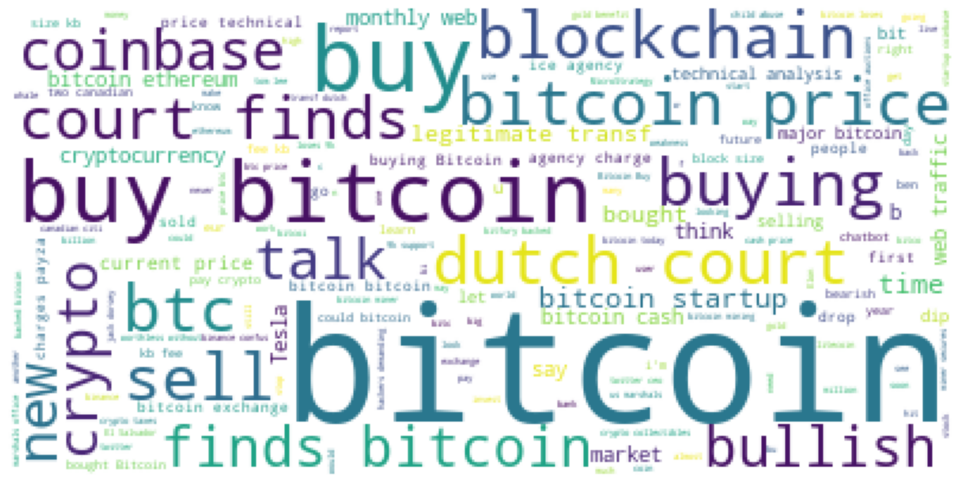

In [43]:
text = final_df.tweet.to_string()
wordcloud = WordCloud(relative_scaling=0.5 , background_color='white',stopwords=set(stopwords.words('english'))).generate(text)
plt.figure(figsize=(17,17))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.savefig("/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/bitcoin-prediction-using-twitter/documents/wordcloud_classifier_dataset")

Now, we can save our dataset.

In [44]:
final_df.to_csv('/Users/anouaroussalah/Desktop/3A/SM10/Deep Learning/Project/dataset_classifier_training.csv', index=False)